In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maternal-and-child-health-monitoring-in-lmics/training_label.csv
/kaggle/input/maternal-and-child-health-monitoring-in-lmics/sample submission.csv
/kaggle/input/maternal-and-child-health-monitoring-in-lmics/gee_features.csv


**We have provided three csv files:"gee_features.csv","sample submission.csv","training_label.csv".
In this notbook,we are going to preprocess the "training_label.csv".This csv file contains the DHSID and the health indicators which we have to predict.**

In [2]:
# Importing the required libraries
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy import stats

Before going with training label,loading some columns of gee_features.csv to understand about this dataset.

In [3]:
# Loading the required columns from the gee_features.csv file for getting an idea about this datasset
columns_to_load = ["DHSID","DHSYEAR","DHSCLUST","LATNUM","ADM1NAME","key1"]
df_gee = pd.read_csv("/kaggle/input/maternal-and-child-health-monitoring-in-lmics/gee_features.csv",usecols=columns_to_load)
df_gee.head()

/tmp/ipykernel_32/3145295238.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gee = pd.read_csv("/kaggle/input/maternal-and-child-health-monitoring-in-lmics/gee_features.csv",usecols=columns_to_load)


,ADM1NAME,DHSCLUST,DHSID,DHSYEAR,LATNUM,key1
0,NaN,1,AL200800000001,2008,40.822650,AL
1,NaN,2,AL200800000002,2008,40.696846,AL
2,NaN,3,AL200800000003,2008,40.750040,AL
3,NaN,4,AL200800000004,2008,40.798930,AL
4,NaN,5,AL200800000005,2008,40.746124,AL


In [4]:
df_gee

,ADM1NAME,DHSCLUST,DHSID,DHSYEAR,LATNUM,key1
0,NaN,1,AL200800000001,2008,40.822650,AL
1,NaN,2,AL200800000002,2008,40.696846,AL
2,NaN,3,AL200800000003,2008,40.750040,AL
3,NaN,4,AL200800000004,2008,40.798930,AL
4,NaN,5,AL200800000005,2008,40.746124,AL
...,...,...,...,...,...,...
120979,Harare,396,ZW201500000396,2015,-17.915289,ZW
120980,Manicaland,397,ZW201500000397,2015,-18.379501,ZW
120981,Mashonaland West,398,ZW201500000398,2015,-16.660612,ZW
120982,Harare,399,ZW201500000399,2015,-17.914251,ZW


So gee_features contains 120984 rows

In [5]:
# Get an idea about the "key1"
df_gee["key1"].unique()

array(['AL', 'AM', 'AO', 'BD', 'BF', 'BJ', 'BO', 'BU', 'CD', 'CF', 'CI',
       'CM', 'CO', 'DR', 'EG', 'ET', 'GA', 'GH', 'GN', 'GU', 'GY', 'HN',
       'HT', 'IA', 'ID', 'JO', 'KE', 'KH', 'KM', 'LB', 'LS', 'MA', 'MB',
       'MD', 'ML', 'MM', 'MW', 'MZ', 'NG', 'NI', 'NM', 'NP', 'PE', 'PH',
       'PK', 'RW', 'SL', 'SN', 'SZ', 'TD', 'TG', 'TJ', 'TL', 'TZ', 'UG',
       'UZ', 'ZA', 'ZM', 'ZW'], dtype=object)

In [6]:
# Finding an idea about the ADMINAME
print(df_gee["ADM1NAME"].isnull().sum())
print(len(df_gee["ADM1NAME"].unique()))

15342
1324


Some values are missing in the column ADM1NAME 

In [7]:
# Loading only required columns of gee_features.csv file
columns_to_load = ["DHSID","DHSYEAR","DHSCLUST","LATNUM","LONGNUM"]
df_gee_1 = pd.read_csv("/kaggle/input/maternal-and-child-health-monitoring-in-lmics/gee_features.csv",usecols=columns_to_load)
df_gee_1.head()

,DHSCLUST,DHSID,DHSYEAR,LATNUM,LONGNUM
0,1,AL200800000001,2008,40.822650,19.838322
1,2,AL200800000002,2008,40.696846,20.007555
2,3,AL200800000003,2008,40.750040,19.974262
3,4,AL200800000004,2008,40.798930,19.863338
4,5,AL200800000005,2008,40.746124,19.843885


**Now starting the preprocessing of the training_label.csv**

In [8]:
# Loading training_label.csv file
df1 = pd.read_csv('/kaggle/input/maternal-and-child-health-monitoring-in-lmics/training_label.csv')
df1

,DHSID,DHSYEAR,DHSCLUST,LATNUM,LONGNUM,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA
0,AL200800000001,2008,1.0,40.822652,19.838321,24.12,25.28,50.00,9.68,100.00,20.00,R
1,AL200800000002,2008,2.0,40.696846,20.007555,23.04,21.98,7.69,8.33,66.67,0.00,R
2,AL200800000004,2008,4.0,40.798931,19.863338,26.74,26.57,7.69,2.86,100.00,0.00,R
3,AL200800000006,2008,6.0,40.711349,19.935309,27.58,28.08,0.00,9.52,NaN,0.00,U
4,AL200800000010,2008,10.0,40.698522,19.950300,24.23,23.77,20.00,23.81,50.00,0.00,U
...,...,...,...,...,...,...,...,...,...,...,...,...
99107,ZW201500000395,2015,395.0,-17.166506,29.718371,21.92,21.08,6.25,9.72,40.00,21.74,R
99108,ZW201500000396,2015,396.0,-17.915288,31.156115,23.16,22.14,33.33,2.04,78.95,25.00,U
99109,ZW201500000397,2015,397.0,-18.379501,31.872287,24.33,22.61,11.11,1.75,76.19,22.22,R
99110,ZW201500000398,2015,398.0,-16.660612,29.850649,23.70,21.44,10.53,4.88,68.00,17.65,R


training_label.csv has 99112 rows and 12 columns

In [9]:

def function_description(df,columns):
    """
    This is a function for descibing the required columns of the data set given and df
    """
    for column in columns:
        print("Desciption of the column '{}' \n " .format(column))
        df[column].info()
        print(df[column].describe())
        print("\n")

In [10]:
# The given below columns needed for our analysis
column_names=  ["Mean_BMI","Median_BMI","Unmet_Need_Rate","Under5_Mortality_Rate","Skilled_Birth_Attendant_Rate","Stunted_Rate"]

In [11]:
# Calling the function
function_description(df1,column_names)

Desciption of the column 'Mean_BMI' 
 
<class 'pandas.core.series.Series'>
RangeIndex: 99112 entries, 0 to 99111
Series name: Mean_BMI
Non-Null Count  Dtype  
--------------  -----  
80595 non-null  float64
dtypes: float64(1)
memory usage: 774.4 KB
count    80595.000000
mean        23.290318
std          3.457067
min         14.150000
25%         20.940000
50%         22.600000
75%         24.770000
max         55.480000
Name: Mean_BMI, dtype: float64


Desciption of the column 'Median_BMI' 
 
<class 'pandas.core.series.Series'>
RangeIndex: 99112 entries, 0 to 99111
Series name: Median_BMI
Non-Null Count  Dtype  
--------------  -----  
80595 non-null  float64
dtypes: float64(1)
memory usage: 774.4 KB
count    80595.000000
mean        22.826448
std          3.534139
min         14.150000
25%         20.480000
50%         22.060000
75%         24.200000
max         55.480000
Name: Median_BMI, dtype: float64


Desciption of the column 'Unmet_Need_Rate' 
 
<class 'pandas.core.series.Serie

This implies that no columns having negative values

In [12]:
# Unique values of DHSYEAR
df1['DHSYEAR'].unique()

array([2008, 2017, 2010, 2015, 2000, 2004, 2007, 2011, 2014, 1993, 1999,
       2003, 1996, 2001, 2012, 2016, 2013, 1994, 1998, 1991, 2018, 1992,
       1995, 2005, 2009, 2006, 2002, 1986, 1997, 1990, 2019, 1988])

In [13]:
df1.DHSID #This contains,the name of the country and the year values.

0        AL200800000001
1        AL200800000002
2        AL200800000004
3        AL200800000006
4        AL200800000010
              ...      
99107    ZW201500000395
99108    ZW201500000396
99109    ZW201500000397
99110    ZW201500000398
99111    ZW201500000400
Name: DHSID, Length: 99112, dtype: object

In [14]:
# Adding a new column called country_codes to the df1,which is the first to letters of the DHSID 
df1['country_codes'] = df1['DHSID'].str[:2]
df1['country_codes'].unique()

array(['AL', 'AM', 'AO', 'BD', 'BF', 'BJ', 'BO', 'BU', 'CD', 'CF', 'CI',
       'CM', 'CO', 'DH', 'DR', 'EG', 'ET', 'GA', 'GH', 'GN', 'GU', 'GY',
       'HN', 'HT', 'IA', 'ID', 'JO', 'KE', 'KH', 'KM', 'LB', 'LS', 'MA',
       'MB', 'MD', 'ML', 'MM', 'MW', 'MZ', 'NG', 'NI', 'NM', 'NP', 'PE',
       'PH', 'PK', 'RW', 'SL', 'SN', 'SZ', 'TD', 'TG', 'TJ', 'TL', 'TZ',
       'UG', 'ZA', 'ZM', 'ZW'], dtype=object)

Here there are 59 country names in total

**Now carrying out the exploratory data analysis to get an idea of the data**

**EXPLORATORY DATA ANALYSIS**

Text(0.5, 0, 'Mean BMI')

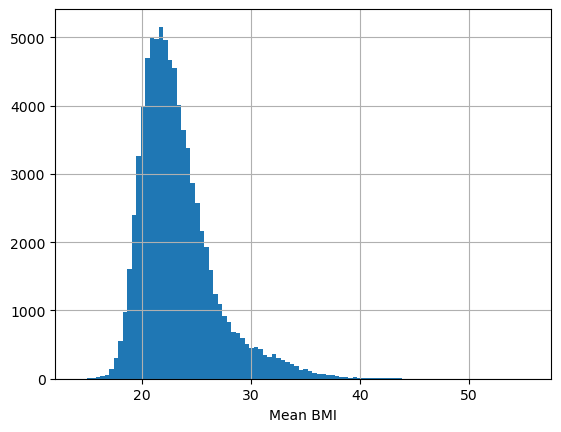

In [15]:
#Plotting the columns
df1["Mean_BMI"].hist(bins=100)
plt.xlabel("Mean BMI")

Text(0.5, 0, 'Median BMI')

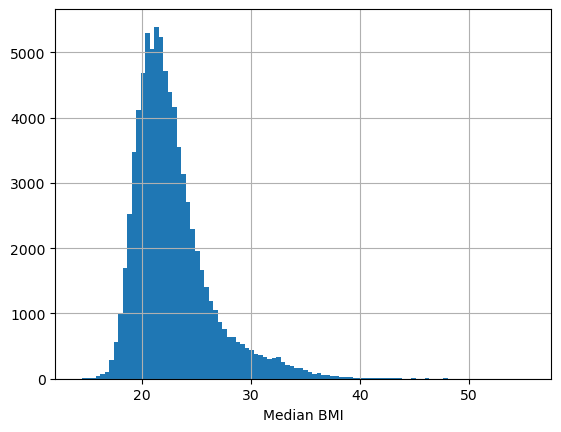

In [16]:
df1["Median_BMI"].hist(bins=100)
plt.xlabel("Median BMI")

Text(0.5, 0, 'Unmet_Need_Rate')

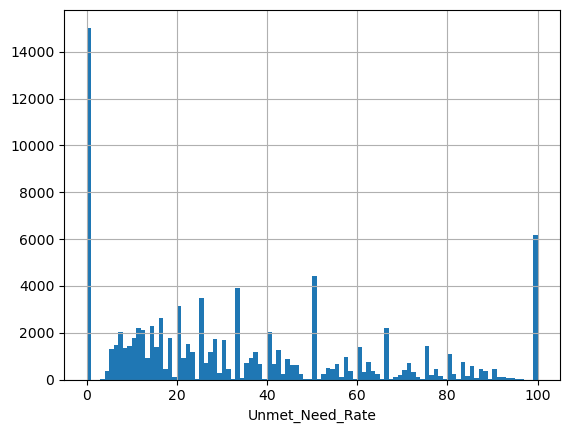

In [17]:
df1["Unmet_Need_Rate"].hist(bins=100)
plt.xlabel("Unmet_Need_Rate")

Text(0.5, 0, 'Under5_Mortality_Rate')

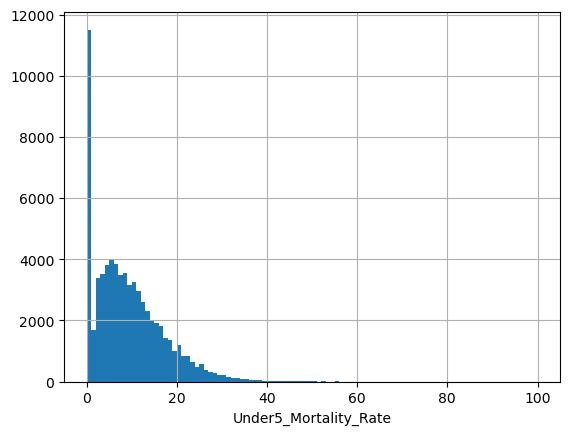

In [18]:
df1["Under5_Mortality_Rate"].hist(bins=100)
plt.xlabel("Under5_Mortality_Rate")

Text(0.5, 0, 'Skilled_Birth_Attendant_Rate')

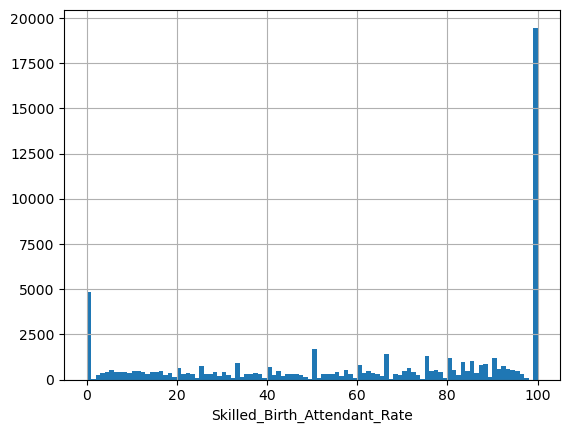

In [19]:
df1["Skilled_Birth_Attendant_Rate"].hist(bins=100)
plt.xlabel("Skilled_Birth_Attendant_Rate")

Text(0.5, 0, 'Stunted_Rate')

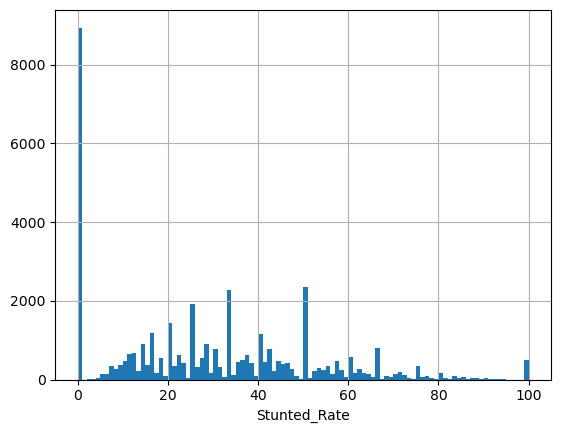

In [20]:
df1["Stunted_Rate"].hist(bins=100)
plt.xlabel("Stunted_Rate")

Finding any relationships exist between the columns

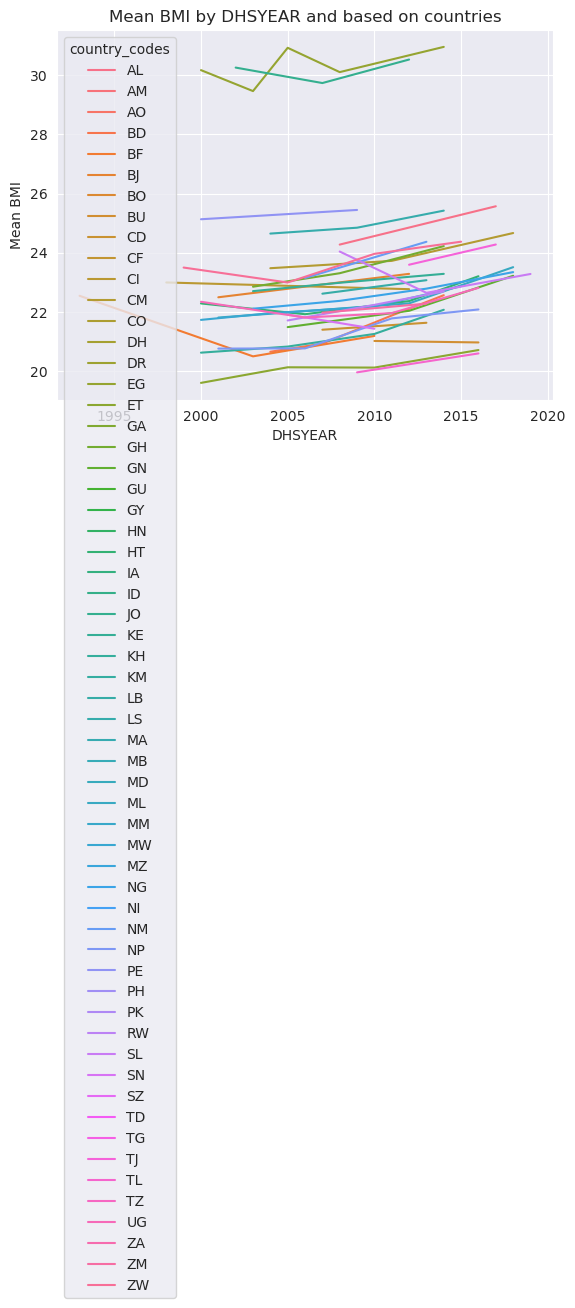

In [21]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(x='DHSYEAR', y="Mean_BMI", hue='country_codes', data=df1,estimator='mean',errorbar=None)

plt.title('Mean BMI by DHSYEAR and based on countries')
plt.xlabel('DHSYEAR')
plt.ylabel('Mean BMI')

plt.show()

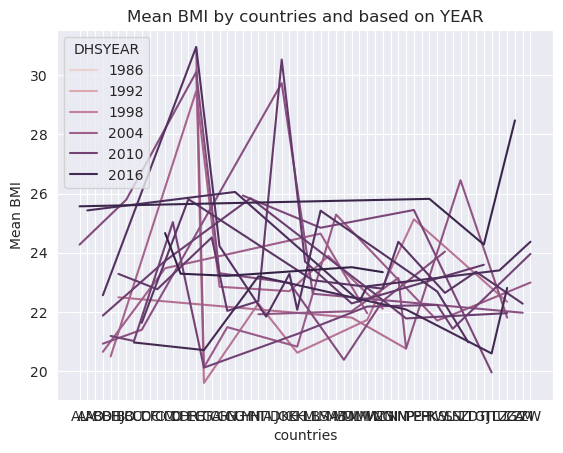

In [22]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(x='country_codes', y="Mean_BMI", hue='DHSYEAR', data=df1,estimator='mean',errorbar=None)

plt.title('Mean BMI by countries and based on YEAR')
plt.xlabel('countries')
plt.ylabel('Mean BMI')

plt.show()

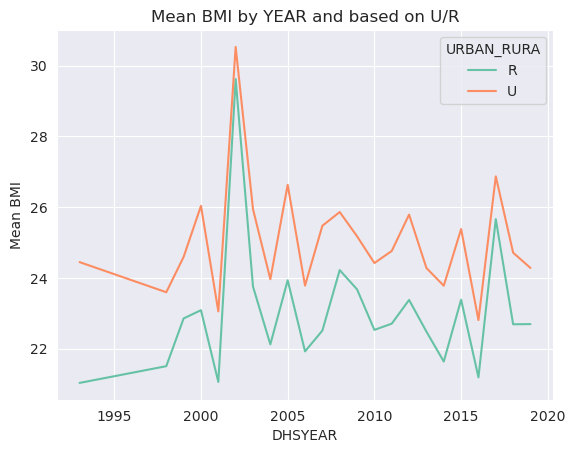

In [23]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(x='DHSYEAR', y="Mean_BMI", hue='URBAN_RURA', data=df1,estimator='mean',errorbar=None)

plt.title('Mean BMI by YEAR and based on U/R')
plt.xlabel('DHSYEAR')
plt.ylabel('Mean BMI')

plt.show()

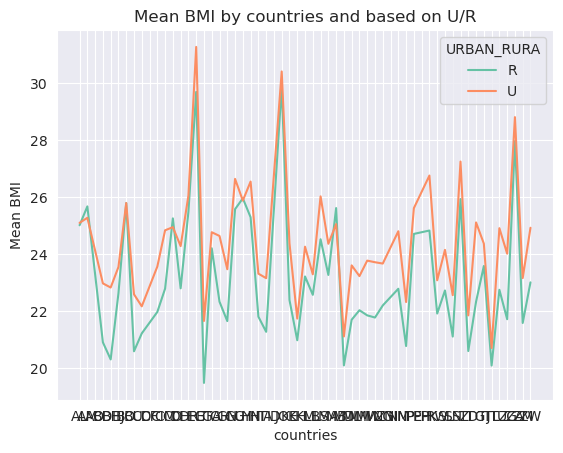

In [24]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(x='country_codes', y="Mean_BMI", hue='URBAN_RURA', data=df1,estimator='mean',errorbar=None)

plt.title('Mean BMI by countries and based on U/R')
plt.xlabel('countries')
plt.ylabel('Mean BMI')

plt.show()

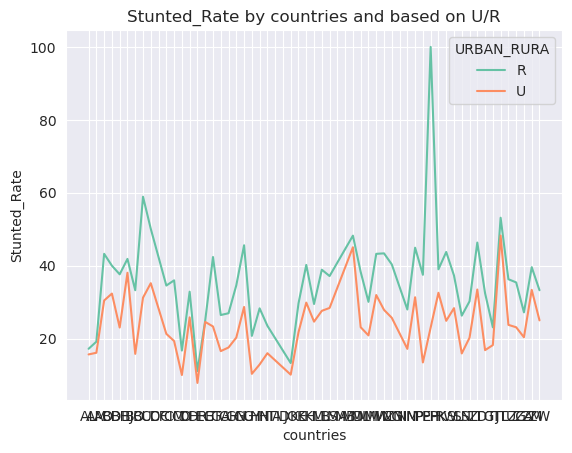

In [25]:
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(x='country_codes', y="Stunted_Rate", hue='URBAN_RURA', data=df1,estimator='mean',errorbar=None)

plt.title('Stunted_Rate by countries and based on U/R')
plt.xlabel('countries')
plt.ylabel('Stunted_Rate')

plt.show()

<Axes: xlabel='country_codes', ylabel='Mean_BMI'>

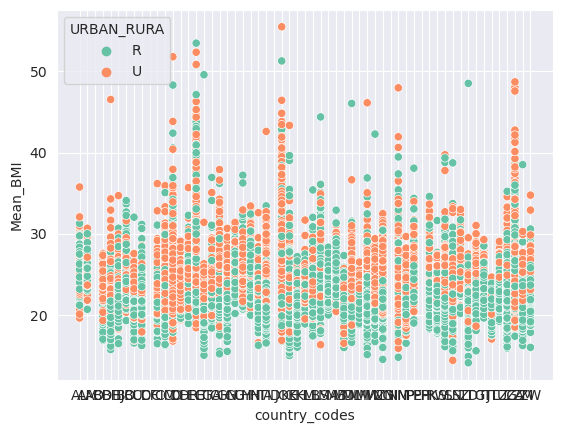

In [26]:
sns.scatterplot(x='country_codes', y="Mean_BMI", hue='URBAN_RURA', data=df1)

**MERGING AND DATA PREPROCESSING**

In [27]:
# Droping the country codes column
df1.drop(columns=["country_codes"],axis=1)

,DHSID,DHSYEAR,DHSCLUST,LATNUM,LONGNUM,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA
0,AL200800000001,2008,1.0,40.822652,19.838321,24.12,25.28,50.00,9.68,100.00,20.00,R
1,AL200800000002,2008,2.0,40.696846,20.007555,23.04,21.98,7.69,8.33,66.67,0.00,R
2,AL200800000004,2008,4.0,40.798931,19.863338,26.74,26.57,7.69,2.86,100.00,0.00,R
3,AL200800000006,2008,6.0,40.711349,19.935309,27.58,28.08,0.00,9.52,NaN,0.00,U
4,AL200800000010,2008,10.0,40.698522,19.950300,24.23,23.77,20.00,23.81,50.00,0.00,U
...,...,...,...,...,...,...,...,...,...,...,...,...
99107,ZW201500000395,2015,395.0,-17.166506,29.718371,21.92,21.08,6.25,9.72,40.00,21.74,R
99108,ZW201500000396,2015,396.0,-17.915288,31.156115,23.16,22.14,33.33,2.04,78.95,25.00,U
99109,ZW201500000397,2015,397.0,-18.379501,31.872287,24.33,22.61,11.11,1.75,76.19,22.22,R
99110,ZW201500000398,2015,398.0,-16.660612,29.850649,23.70,21.44,10.53,4.88,68.00,17.65,R


In [28]:
# Merging the df1 and df_gee_1
df = pd.merge(df_gee_1,df1,on="DHSID",how="left")
df.shape

(120986, 17)

In [29]:
# Adding a new column to df called country_codes
df['country_codes'] = df['DHSID'].str[:2]
df['country_codes'].unique()

array(['AL', 'AM', 'AO', 'BD', 'DH', 'BF', 'BJ', 'BO', 'BU', 'CD', 'CF',
       'CI', 'CM', 'CO', 'DR', 'EG', 'ET', 'GA', 'GH', 'GN', 'GU', 'GY',
       'HN', 'HT', 'IA', 'ID', 'JO', 'KE', 'KH', 'KM', 'LB', 'LS', 'MA',
       'MB', 'MD', 'ML', 'MM', 'MW', 'MZ', 'NG', 'NI', 'NM', 'NP', 'PE',
       'PH', 'PK', 'RW', 'SL', 'SN', 'SZ', 'TD', 'TG', 'TJ', 'TL', 'TZ',
       'UG', 'UZ', 'ZA', 'ZM', 'ZW'], dtype=object)

In [30]:
df.head()

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,DHSYEAR_y,DHSCLUST_y,LATNUM_y,LONGNUM_y,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,2008.0,1.0,40.822652,19.838321,24.12,25.28,50.00,9.68,100.00,20.0,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,2008.0,2.0,40.696846,20.007555,23.04,21.98,7.69,8.33,66.67,0.0,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,2008.0,4.0,40.798931,19.863338,26.74,26.57,7.69,2.86,100.00,0.0,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL


In [31]:
# All column names of the df
df.columns

Index(['DHSCLUST_x', 'DHSID', 'DHSYEAR_x', 'LATNUM_x', 'LONGNUM_x',
       'DHSYEAR_y', 'DHSCLUST_y', 'LATNUM_y', 'LONGNUM_y', 'Mean_BMI',
       'Median_BMI', 'Unmet_Need_Rate', 'Under5_Mortality_Rate',
       'Skilled_Birth_Attendant_Rate', 'Stunted_Rate', 'URBAN_RURA',
       'country_codes'],
      dtype='object')

In [32]:
# Finding the countries which are not in the submission file,which are in training_label
df_submission = pd.read_csv("/kaggle/input/maternal-and-child-health-monitoring-in-lmics/sample submission.csv")
df_submission['country_codes'] = df_submission['DHSID'].str[:2]
a = set(df_submission['country_codes'].unique())

In [33]:
b = set(df['country_codes'].unique())

In [34]:
b-a

{'AO', 'CF', 'IA', 'ID', 'MA', 'MB', 'NI', 'PH', 'UZ'}

These column names are missing from the submission file

In [35]:
# Droping the columns which are not required fro analysis
drop_columns = ["DHSYEAR_y","DHSCLUST_y","LATNUM_y","LONGNUM_y"]
df_1 = df.drop(columns = drop_columns)
df_1

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,24.12,25.28,50.00,9.68,100.00,20.00,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,23.04,21.98,7.69,8.33,66.67,0.00,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,26.74,26.57,7.69,2.86,100.00,0.00,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120981,396,ZW201500000396,2015,-17.915289,31.156115,23.16,22.14,33.33,2.04,78.95,25.00,U,ZW
120982,397,ZW201500000397,2015,-18.379501,31.872288,24.33,22.61,11.11,1.75,76.19,22.22,R,ZW
120983,398,ZW201500000398,2015,-16.660612,29.850649,23.70,21.44,10.53,4.88,68.00,17.65,R,ZW
120984,399,ZW201500000399,2015,-17.914251,30.956976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZW


In [36]:
# Defining a function for finding the missing portion in each columns 
def missing_portion(df,column_names):
    
    #Using a loop to find the missing portion
    for column in column_names:
        missing_percentage = (df[column].isna().mean())*100
        print('Column {} contains [{}] percentage missing'.format(column,missing_percentage))

In [37]:
columns =  ["Mean_BMI","Median_BMI","Unmet_Need_Rate","Under5_Mortality_Rate","Skilled_Birth_Attendant_Rate","Stunted_Rate"]
missing_portion(df_1,columns)

Column Mean_BMI contains [32.94430760583869] percentage missing
Column Median_BMI contains [32.94430760583869] percentage missing
Column Unmet_Need_Rate contains [17.976460086290977] percentage missing
Column Under5_Mortality_Rate contains [40.267468963351135] percentage missing
Column Skilled_Birth_Attendant_Rate contains [43.32650058684476] percentage missing
Column Stunted_Rate contains [64.22561288082919] percentage missing


Here in each column a certain percentage is missing.First we have to find this missing values are replace the Nan values with our assumptions

Now going to find a new dataframe for finding the nummber of values in each countries

In [38]:
# Couting the data points in each countries and formiing a new data frame with country codes,and count of values in each countries

country_counts = df_1["country_codes"].value_counts()
df_country_counts = pd.DataFrame({ 'country codes': country_counts.index,'country count': country_counts.values})
df2 = df_1[["Mean_BMI","Median_BMI","Unmet_Need_Rate","Under5_Mortality_Rate","Skilled_Birth_Attendant_Rate","Stunted_Rate","country_codes"]].groupby("country_codes").count()
df3 = df_country_counts.set_index('country codes').join(df2)


Now going to analyzing the missing percentage of columns by country

In [39]:
df3["Mean_BMI_percent"] = df3["Mean_BMI"]/df3["country count"]*100

In [40]:
df3[df3["Mean_BMI_percent"]==0]

,country count,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,Mean_BMI_percent
country codes,,,,,,,,
PH,2861,0,0,2840,2854,2824,1,0.0
ID,1392,0,0,1389,1391,1387,0,0.0
AO,625,0,0,624,625,625,625,0.0
NI,503,0,0,489,503,268,0,0.0
CF,231,0,0,223,231,230,0,0.0
UZ,219,0,0,0,0,0,0,0.0


These countries have complete missing of Mean_BMI data

In [41]:
df3["UNR_Percent"] = df3["Unmet_Need_Rate"]/df3["country count"]*100

In [42]:
df3[df3["UNR_Percent"]==0]

,country count,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,Mean_BMI_percent,UNR_Percent
country codes,,,,,,,,,
UZ,219,0,0,0,0,0,0,0.0,0.0


This country have Unmet_Need_Rate completely missing

In [43]:
df3["U5M_Percentage"] = df3["Under5_Mortality_Rate"]/df3["country count"]*100

In [44]:
df3[df3["U5M_Percentage"]==0]

,country count,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,Mean_BMI_percent,UNR_Percent,U5M_Percentage
country codes,,,,,,,,,,
IA,27743,27726,27726,27684,0,0,0,99.938723,99.787334,0.0
UZ,219,0,0,0,0,0,0,0.000000,0.000000,0.0


These contries have completely missing values of the Under5_Mortality_Rate

In [45]:
df3["SBA_Percentage"] = df3["Skilled_Birth_Attendant_Rate"]/df3["country count"]*100

In [46]:
df3[df3["SBA_Percentage"]==0]

,country count,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,Mean_BMI_percent,UNR_Percent,U5M_Percentage,SBA_Percentage
country codes,,,,,,,,,,,
IA,27743,27726,27726,27684,0,0,0,99.938723,99.787334,0.0,0.0
UZ,219,0,0,0,0,0,0,0.000000,0.000000,0.0,0.0


These countries have Skilled_Birth_Attendant_Rate completely missing

In [47]:
df3["SR_Percentage"] = df3["Stunted_Rate"]/df3["country count"]*100

In [48]:
df3[df3["SR_Percentage"]==0]

,country count,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,Mean_BMI_percent,UNR_Percent,U5M_Percentage,SBA_Percentage,SR_Percentage
country codes,,,,,,,,,,,,
IA,27743,27726,27726,27684,0,0,0,99.938723,99.787334,0.000000,0.000000,0.0
ID,1392,0,0,1389,1391,1387,0,0.000000,99.784483,99.928161,99.640805,0.0
MB,800,800,800,800,800,774,0,100.000000,100.000000,100.000000,96.750000,0.0
NI,503,0,0,489,503,268,0,0.000000,97.216700,100.000000,53.280318,0.0
MA,480,480,480,480,480,480,0,100.000000,100.000000,100.000000,100.000000,0.0
CF,231,0,0,223,231,230,0,0.000000,96.536797,100.000000,99.567100,0.0
UZ,219,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0


These countries have completely missing Stunted_Rate 

Droping these country names,since missing values are more ie;"PH","ID","AO","CF","NI","IA","MA","MB","UZ"

In [49]:
df_2 = df_1.copy()

drop_country_codes = ["PH","ID","AO","CF","NI","IA","MA","MB","UZ"]
df_2 = df_2[~df_2["country_codes"].isin(drop_country_codes)]
df_2.shape

(86132, 13)

In [50]:
# Calling the same function which we have declared earlier
missing_portion(df_2,columns)

Column Mean_BMI contains [39.485905354572054] percentage missing
Column Median_BMI contains [39.485905354572054] percentage missing
Column Unmet_Need_Rate contains [24.873450053406398] percentage missing
Column Under5_Mortality_Rate contains [24.088608182789205] percentage missing
Column Skilled_Birth_Attendant_Rate contains [28.041842752983793] percentage missing
Column Stunted_Rate contains [50.476013560581436] percentage missing


Here the missing portion has changed

In [51]:
df_2

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,24.12,25.28,50.00,9.68,100.00,20.00,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,23.04,21.98,7.69,8.33,66.67,0.00,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,26.74,26.57,7.69,2.86,100.00,0.00,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120981,396,ZW201500000396,2015,-17.915289,31.156115,23.16,22.14,33.33,2.04,78.95,25.00,U,ZW
120982,397,ZW201500000397,2015,-18.379501,31.872288,24.33,22.61,11.11,1.75,76.19,22.22,R,ZW
120983,398,ZW201500000398,2015,-16.660612,29.850649,23.70,21.44,10.53,4.88,68.00,17.65,R,ZW
120984,399,ZW201500000399,2015,-17.914251,30.956976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZW


Now going to replace the missing values with the mean of features on country basis

In [52]:
from sklearn.impute import SimpleImputer

# Grouping the values based on countries
grouped_country = df_2.groupby(["country_codes"])
#Iterating over each group in (country_codes,group values)
for country, group in grouped_country:
    
    #iterating over each columns in column_names
    for column in column_names:
        
        #Skipping imputation,if all values of a column is Nan
        if group[column].isnull().all():
            continue
            
        #Finding the missing values using 'mean'
        else:
            imputer = SimpleImputer(strategy = 'mean')
            group[column] = imputer.fit_transform(group[[column]])
    
    # Filling missing values in the group directly
    group.fillna(group.mean(), inplace=True)
    # Updating the DataFrame df1 with new values
    df_2.loc[group.index] = group

/tmp/ipykernel_32/4196767890.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for country, group in grouped_country:
/tmp/ipykernel_32/4196767890.py:21: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  group.fillna(group.mean(), inplace=True)
/tmp/ipykernel_32/4196767890.py:21: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  group.fillna(group.mean(), inplace=T

In [53]:
# Calling the function missing_portion to find the missing portion in each columns
missing_portion(df_2,column_names)

Column Mean_BMI contains [0.0] percentage missing
Column Median_BMI contains [0.0] percentage missing
Column Unmet_Need_Rate contains [0.0] percentage missing
Column Under5_Mortality_Rate contains [0.0] percentage missing
Column Skilled_Birth_Attendant_Rate contains [0.0] percentage missing
Column Stunted_Rate contains [0.0] percentage missing


Now missing portion changed to zero portion.So removing the outliers

In [54]:
# Calling the function function_description for describing the required columns
function_description(df_2,columns)

Desciption of the column 'Mean_BMI' 
 
<class 'pandas.core.series.Series'>
Int64Index: 86132 entries, 0 to 120985
Series name: Mean_BMI
Non-Null Count  Dtype  
--------------  -----  
86132 non-null  float64
dtypes: float64(1)
memory usage: 3.3 MB
count    86132.000000
mean        24.172922
std          3.439272
min         14.150000
25%         21.850000
50%         23.393463
75%         25.810457
max         55.480000
Name: Mean_BMI, dtype: float64


Desciption of the column 'Median_BMI' 
 
<class 'pandas.core.series.Series'>
Int64Index: 86132 entries, 0 to 120985
Series name: Median_BMI
Non-Null Count  Dtype  
--------------  -----  
86132 non-null  float64
dtypes: float64(1)
memory usage: 3.3 MB
count    86132.000000
mean        23.707718
std          3.499149
min         14.150000
25%         21.360000
50%         22.839259
75%         25.232087
max         55.480000
Name: Median_BMI, dtype: float64


Desciption of the column 'Unmet_Need_Rate' 
 
<class 'pandas.core.series.Series'

**Outlier Removal using z-scores**

Putting a threshold of 3 and removing the outliers when the absolute z-scores greater than 3

In [55]:
def outlier_removal_z_score_calculation(df,columns):
    """
     Function to find the z scores of required columns and removing those rows
    """
    df_cleaned =df.copy()
    z_scores = np.abs(stats.zscore(df_cleaned[columns]))
    threshold = 3
    outlier_indices = np.where(z_scores>threshold)[0]
    df_cleaned = df_cleaned.drop(df_cleaned.index[outlier_indices])
    
    return df_cleaned

In [56]:
column_names

['Mean_BMI',
 'Median_BMI',
 'Unmet_Need_Rate',
 'Under5_Mortality_Rate',
 'Skilled_Birth_Attendant_Rate',
 'Stunted_Rate']

In [58]:
df_3 = outlier_removal_z_score_calculation(df_2,column_names)

In [59]:
df_3

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,24.120000,25.280000,50.000000,9.680000,100.000000,20.000000,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,23.040000,21.980000,7.690000,8.330000,66.670000,0.000000,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,26.740000,26.570000,7.690000,2.860000,100.000000,0.000000,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120981,396,ZW201500000396,2015,-17.915289,31.156115,23.160000,22.140000,33.330000,2.040000,78.950000,25.000000,U,ZW
120982,397,ZW201500000397,2015,-18.379501,31.872288,24.330000,22.610000,11.110000,1.750000,76.190000,22.220000,R,ZW
120983,398,ZW201500000398,2015,-16.660612,29.850649,23.700000,21.440000,10.530000,4.880000,68.000000,17.650000,R,ZW
120984,399,ZW201500000399,2015,-17.914251,30.956976,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275,NaN,ZW


In [60]:
filtered_df = df_3[(df_3["LATNUM_x"] == 0) & (df_3["LONGNUM_x"] == 0)]
filtered_df

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
3076,514,BD200400000514,2004,0.0,0.0,23.220000,23.720000,0.000000,8.770000,35.710000,37.396413,U,BD
3077,515,BD200400000515,2004,0.0,0.0,20.670000,20.610000,20.000000,17.810000,0.000000,37.396413,U,BD
4617,544,BD201400000544,2014,0.0,0.0,20.650000,19.830000,14.290000,9.090000,14.290000,0.000000,R,BD
5687,155,BF199900000155,1999,0.0,0.0,21.057506,20.795384,90.910000,17.790000,8.000000,33.191939,R,BF
5847,119,BF200300000119,2003,0.0,0.0,23.730000,23.180000,7.690000,10.000000,93.750000,33.191939,U,BF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120441,262,ZW201000000262,2010,0.0,0.0,23.080000,20.860000,15.380000,14.140000,43.750000,38.460000,R,ZW
120502,323,ZW201000000323,2010,0.0,0.0,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275,NaN,ZW
120523,344,ZW201000000344,2010,0.0,0.0,24.550000,23.690000,0.000000,0.000000,100.000000,20.000000,U,ZW
120559,380,ZW201000000380,2010,0.0,0.0,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275,NaN,ZW


Droping these rows

In [61]:
# Droping these rows from the data frame
df_4 = df_3.drop(filtered_df.index)
df_4

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,24.120000,25.280000,50.000000,9.680000,100.000000,20.000000,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,23.040000,21.980000,7.690000,8.330000,66.670000,0.000000,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,26.740000,26.570000,7.690000,2.860000,100.000000,0.000000,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120981,396,ZW201500000396,2015,-17.915289,31.156115,23.160000,22.140000,33.330000,2.040000,78.950000,25.000000,U,ZW
120982,397,ZW201500000397,2015,-18.379501,31.872288,24.330000,22.610000,11.110000,1.750000,76.190000,22.220000,R,ZW
120983,398,ZW201500000398,2015,-16.660612,29.850649,23.700000,21.440000,10.530000,4.880000,68.000000,17.650000,R,ZW
120984,399,ZW201500000399,2015,-17.914251,30.956976,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275,NaN,ZW


In [62]:
# Finding the duplicate rows with same latitudes,longitude,DHSID
duplicate_rows = df_4[df_4.duplicated(subset=["LATNUM_x","LONGNUM_x","DHSID"], keep=False)]
duplicate_rows

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
18790,1,DR200700000001,2007,19.644573,-70.445830,25.810457,25.232087,30.77000,0.000000,20.000000,20.000000,U,DR
18791,1,DR200700000001,2007,19.644573,-70.445830,25.810457,25.232087,30.77000,0.000000,20.000000,20.000000,U,DR
18792,5,DR200700000005,2007,18.573294,-70.000520,25.810457,25.232087,6.25000,5.660000,100.000000,0.000000,U,DR
18793,5,DR200700000005,2007,18.573294,-70.000520,25.810457,25.232087,6.25000,5.660000,100.000000,0.000000,U,DR
18794,10,DR200700000010,2007,19.493880,-70.712090,25.810457,25.232087,15.38000,5.880000,70.000000,0.000000,U,DR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119002,720,ZM201300000720,2013,-15.385706,28.258770,22.221429,21.694873,34.89381,9.616695,68.954874,37.700448,NaN,ZM
119003,721,ZM201300000721,2013,-16.016170,23.462543,19.400000,18.080000,60.00000,20.450000,65.000000,33.330000,R,ZM
119004,721,ZM201300000721,2013,-16.016170,23.462543,19.400000,18.080000,60.00000,20.450000,65.000000,33.330000,R,ZM
119005,722,ZM201300000722,2013,-15.365589,28.399462,22.221429,21.694873,34.89381,9.616695,68.954874,37.700448,NaN,ZM


In [63]:
# Retaining one row among each duplicates and deleting other rows
df_4.drop_duplicates(subset=["LATNUM_x", "LONGNUM_x", "DHSID"], keep="first", inplace=True)

In [64]:
df_4

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,24.120000,25.280000,50.000000,9.680000,100.000000,20.000000,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,23.040000,21.980000,7.690000,8.330000,66.670000,0.000000,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,26.740000,26.570000,7.690000,2.860000,100.000000,0.000000,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120981,396,ZW201500000396,2015,-17.915289,31.156115,23.160000,22.140000,33.330000,2.040000,78.950000,25.000000,U,ZW
120982,397,ZW201500000397,2015,-18.379501,31.872288,24.330000,22.610000,11.110000,1.750000,76.190000,22.220000,R,ZW
120983,398,ZW201500000398,2015,-16.660612,29.850649,23.700000,21.440000,10.530000,4.880000,68.000000,17.650000,R,ZW
120984,399,ZW201500000399,2015,-17.914251,30.956976,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275,NaN,ZW


In [65]:
# Finding duplicate rows with same DHSID
duplicate_rows = df_4[df_4.duplicated(subset=["DHSID"], keep=False)]
duplicate_rows

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
8547,2007,BO200800002008,2008,-16.517523,-68.134930,23.655,21.815,0.0,3.845,100.0,25.0,U,BO
8548,2008,BO200800002008,2008,-16.482490,-68.128654,23.655,21.815,0.0,3.845,100.0,25.0,U,BO


In [66]:
# Droping the duplicated row keeeping the first one
df_4.drop_duplicates(subset=[ "DHSID"], keep="first", inplace=True)

In [67]:
# Resting the index
df_4.reset_index(drop=True, inplace=True)

In [68]:
df_4

,DHSCLUST_x,DHSID,DHSYEAR_x,LATNUM_x,LONGNUM_x,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate,URBAN_RURA,country_codes
0,1,AL200800000001,2008,40.822650,19.838322,24.120000,25.280000,50.000000,9.680000,100.000000,20.000000,R,AL
1,2,AL200800000002,2008,40.696846,20.007555,23.040000,21.980000,7.690000,8.330000,66.670000,0.000000,R,AL
2,3,AL200800000003,2008,40.750040,19.974262,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
3,4,AL200800000004,2008,40.798930,19.863338,26.740000,26.570000,7.690000,2.860000,100.000000,0.000000,R,AL
4,5,AL200800000005,2008,40.746124,19.843885,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095,NaN,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77943,396,ZW201500000396,2015,-17.915289,31.156115,23.160000,22.140000,33.330000,2.040000,78.950000,25.000000,U,ZW
77944,397,ZW201500000397,2015,-18.379501,31.872288,24.330000,22.610000,11.110000,1.750000,76.190000,22.220000,R,ZW
77945,398,ZW201500000398,2015,-16.660612,29.850649,23.700000,21.440000,10.530000,4.880000,68.000000,17.650000,R,ZW
77946,399,ZW201500000399,2015,-17.914251,30.956976,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275,NaN,ZW


In [69]:
# Now removing the non required columns
df_5 = df_4.drop(columns = ["DHSCLUST_x","DHSYEAR_x","LATNUM_x","LONGNUM_x","URBAN_RURA","country_codes"])

In [70]:
df_5

,DHSID,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate
0,AL200800000001,24.120000,25.280000,50.000000,9.680000,100.000000,20.000000
1,AL200800000002,23.040000,21.980000,7.690000,8.330000,66.670000,0.000000
2,AL200800000003,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095
3,AL200800000004,26.740000,26.570000,7.690000,2.860000,100.000000,0.000000
4,AL200800000005,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095
...,...,...,...,...,...,...,...
77943,ZW201500000396,23.160000,22.140000,33.330000,2.040000,78.950000,25.000000
77944,ZW201500000397,24.330000,22.610000,11.110000,1.750000,76.190000,22.220000
77945,ZW201500000398,23.700000,21.440000,10.530000,4.880000,68.000000,17.650000
77946,ZW201500000399,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275


**EXPLORATORY DATA ANALYSIS**

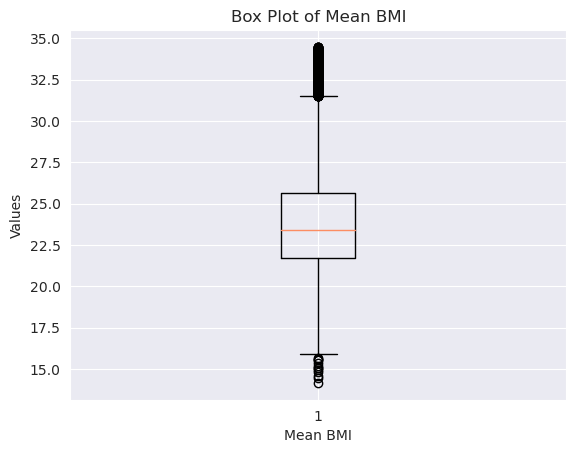

In [71]:
plt.boxplot(df_5["Mean_BMI"])
plt.title('Box Plot of Mean BMI')
plt.xlabel('Mean BMI')
plt.ylabel('Values')
plt.show()

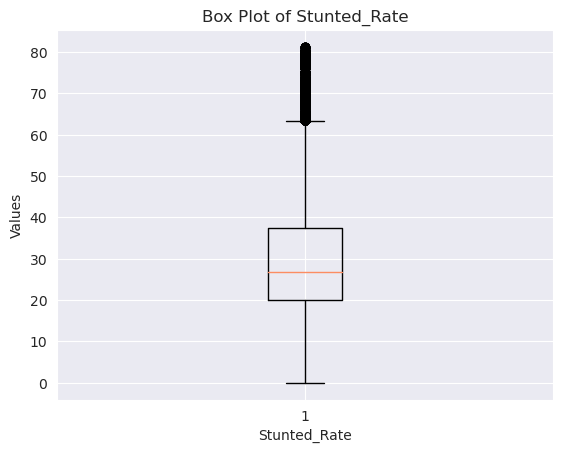

In [72]:
plt.boxplot(df_5["Stunted_Rate"])
plt.title('Box Plot of Stunted_Rate')
plt.xlabel('Stunted_Rate')
plt.ylabel('Values')
plt.show()

In [73]:
# Comparing plots
def comparison_plots(df,column):
    '''
    This function is used for comparing the distribution
    '''
    plt.figure(figsize=(40,5))
    plt.subplot(1,2,1)
    sns.histplot(df[column],bins=100,kde=True,color='g')
    plt.title(column,loc='center')
    
    plt.subplot(1,2,2)
    sns.boxplot(df[column])
    plt.title(column)
    
    plt.show()


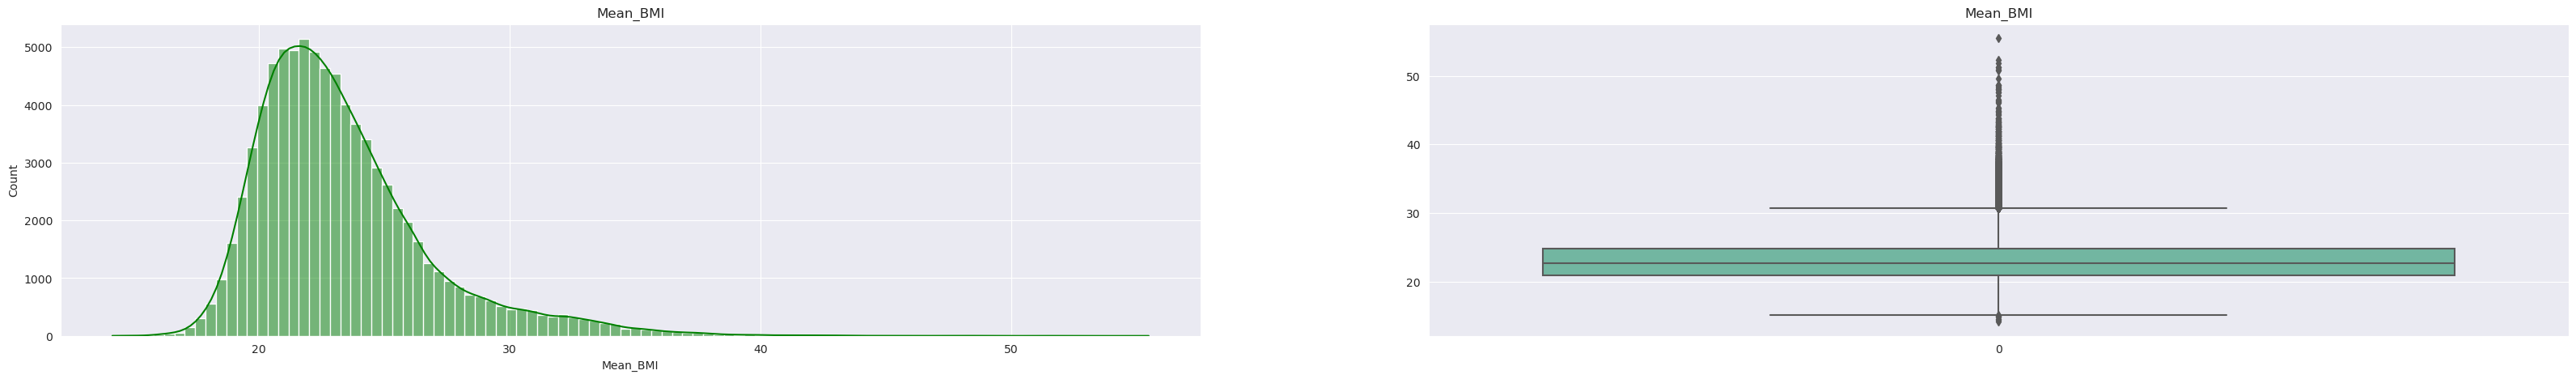

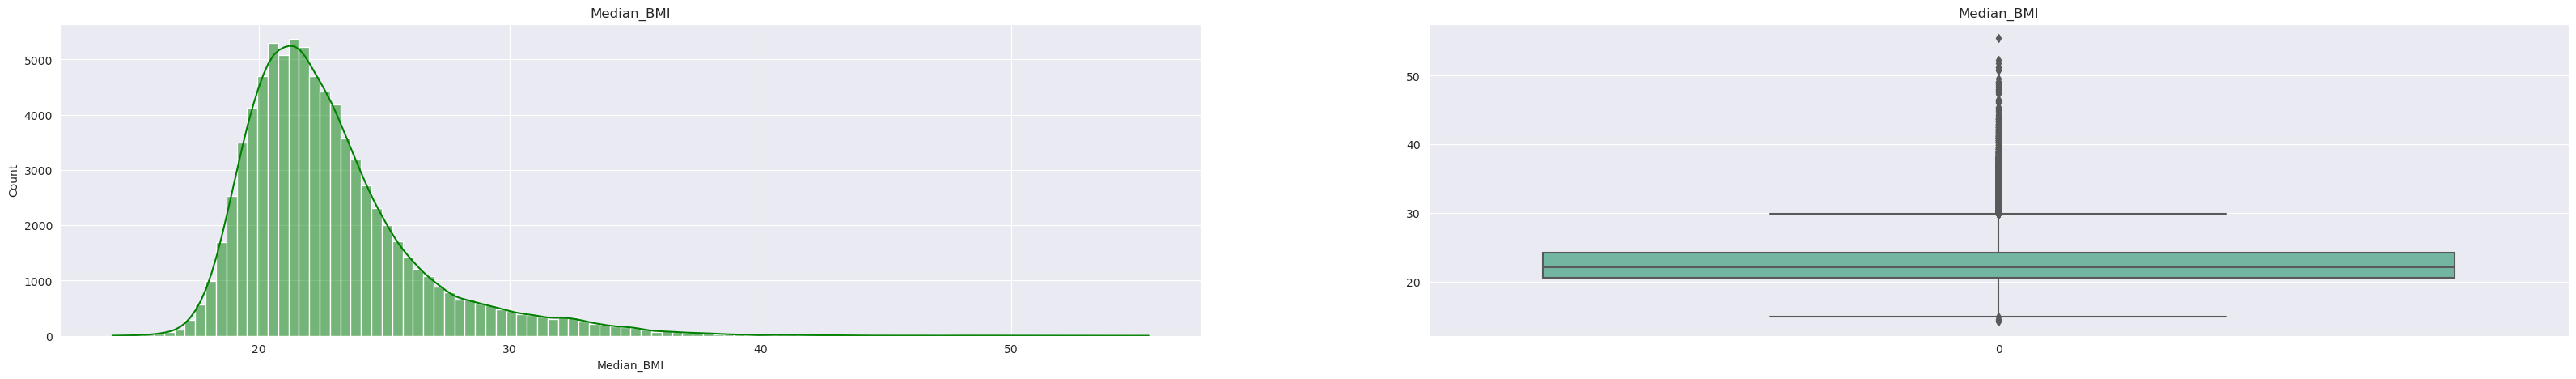

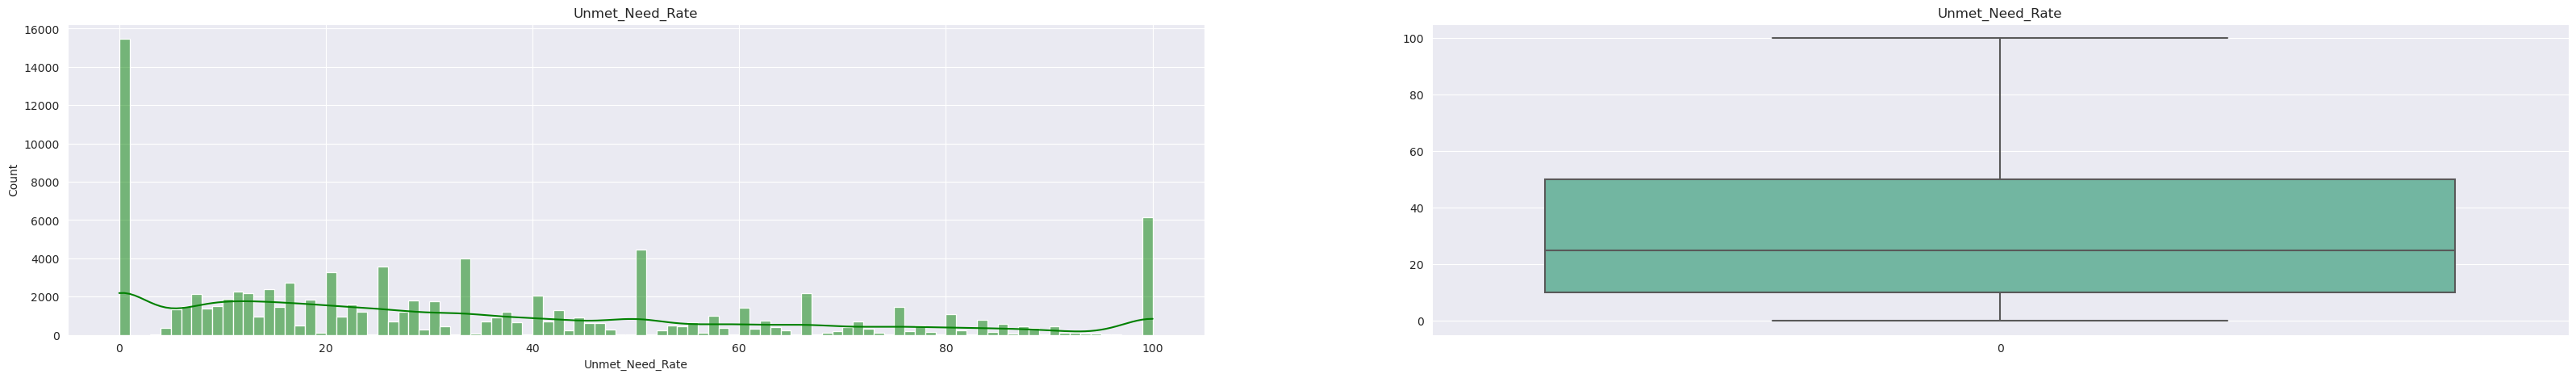

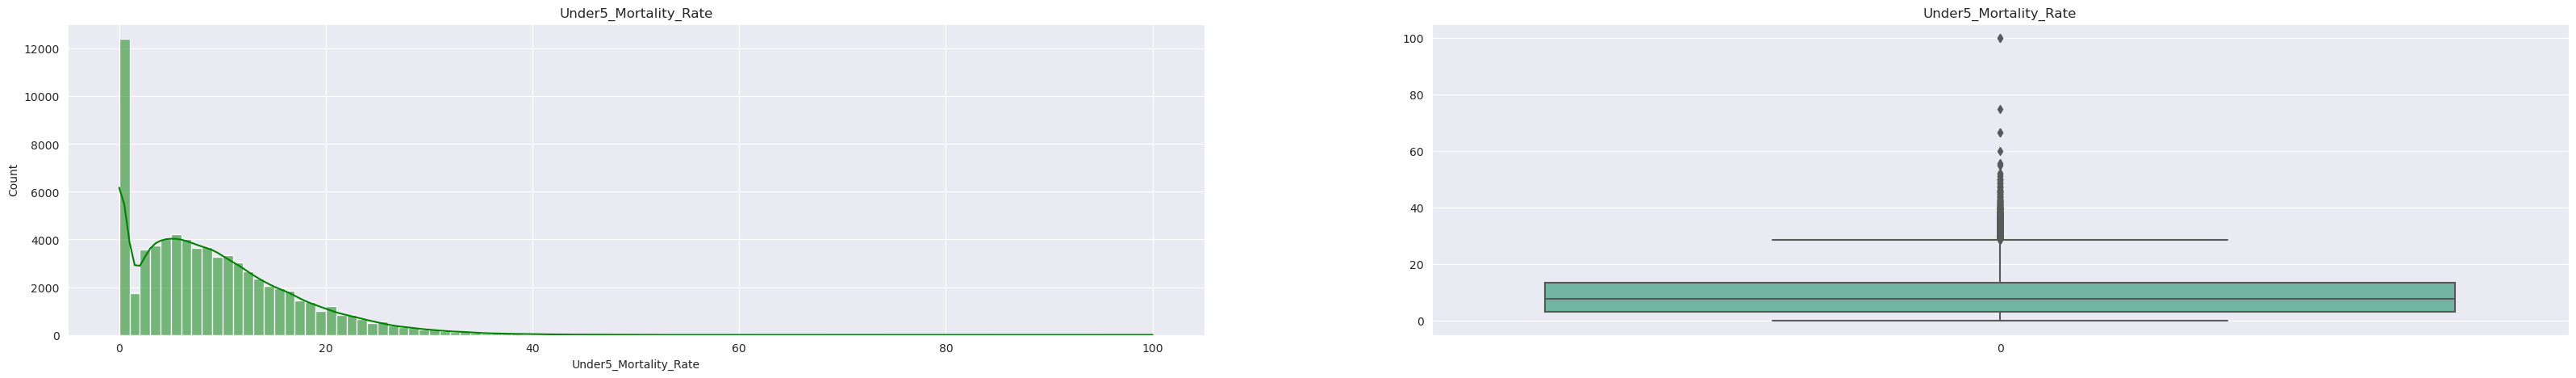

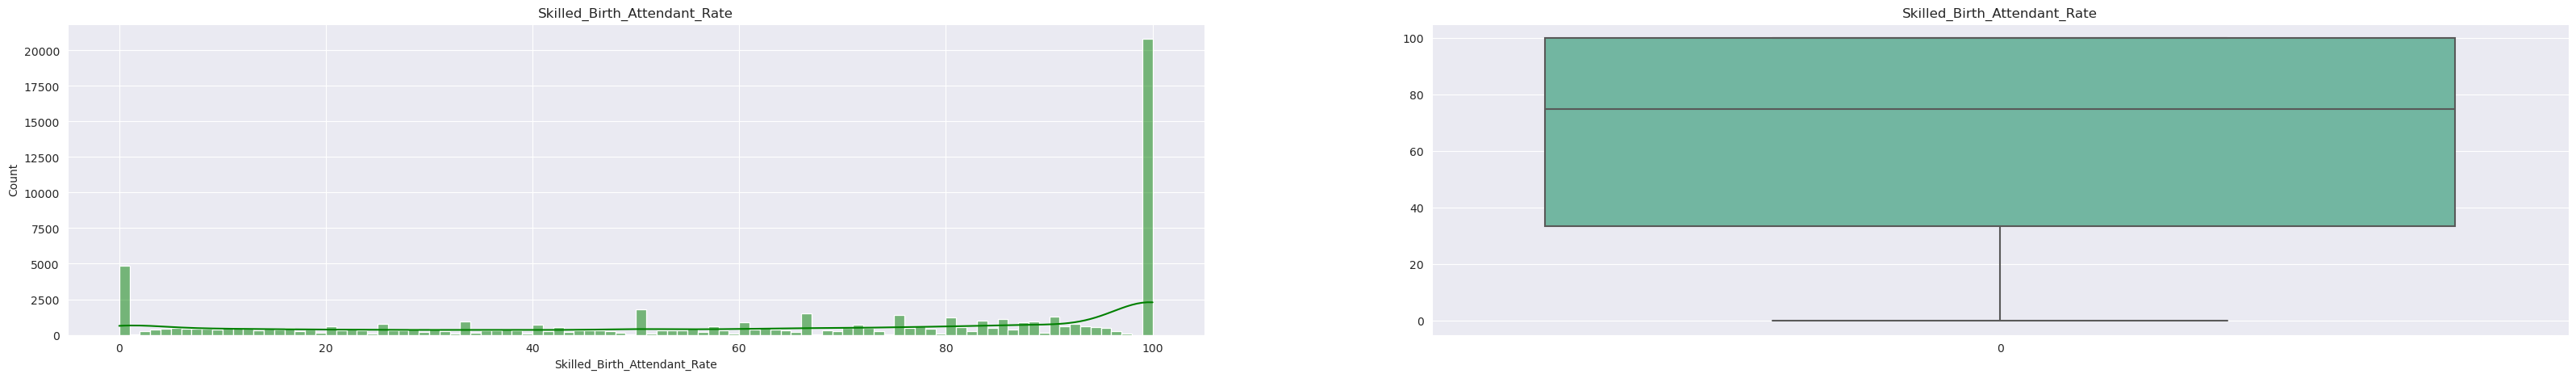

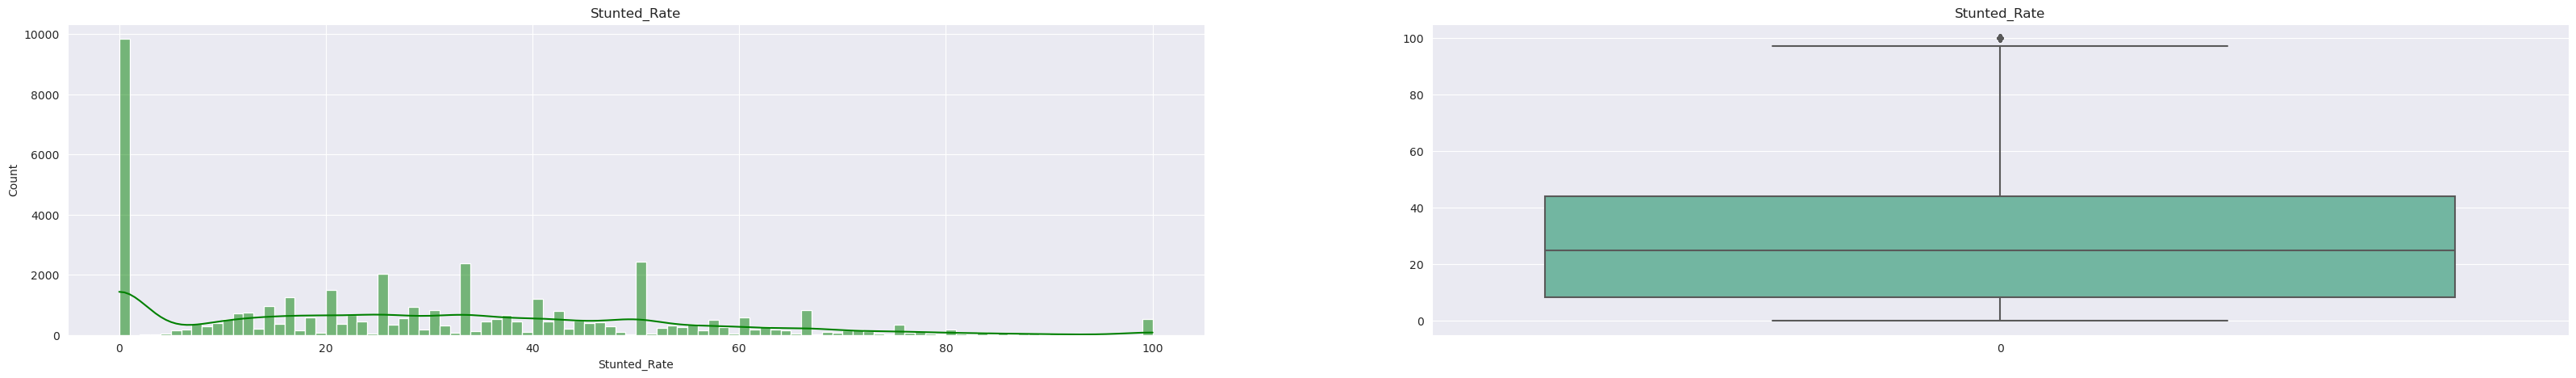

In [74]:
for column in column_names:
    comparison_plots(df_1,column)

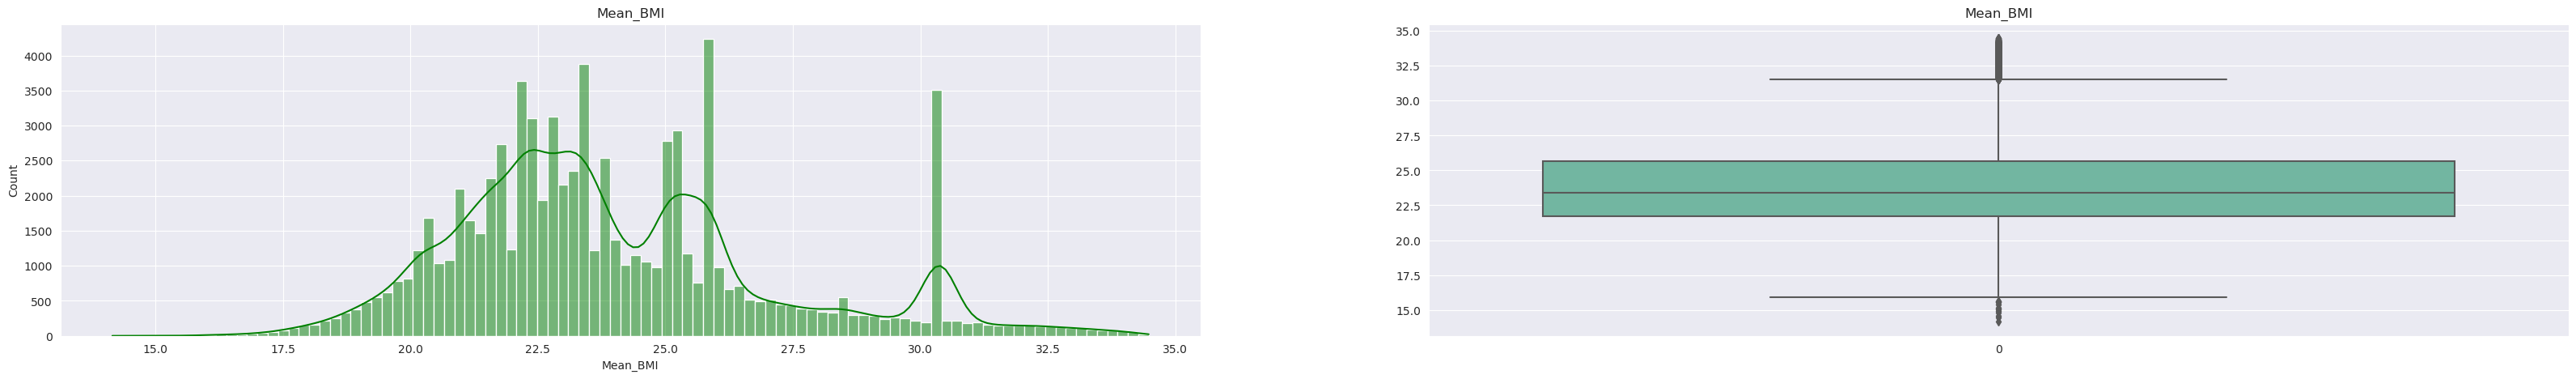

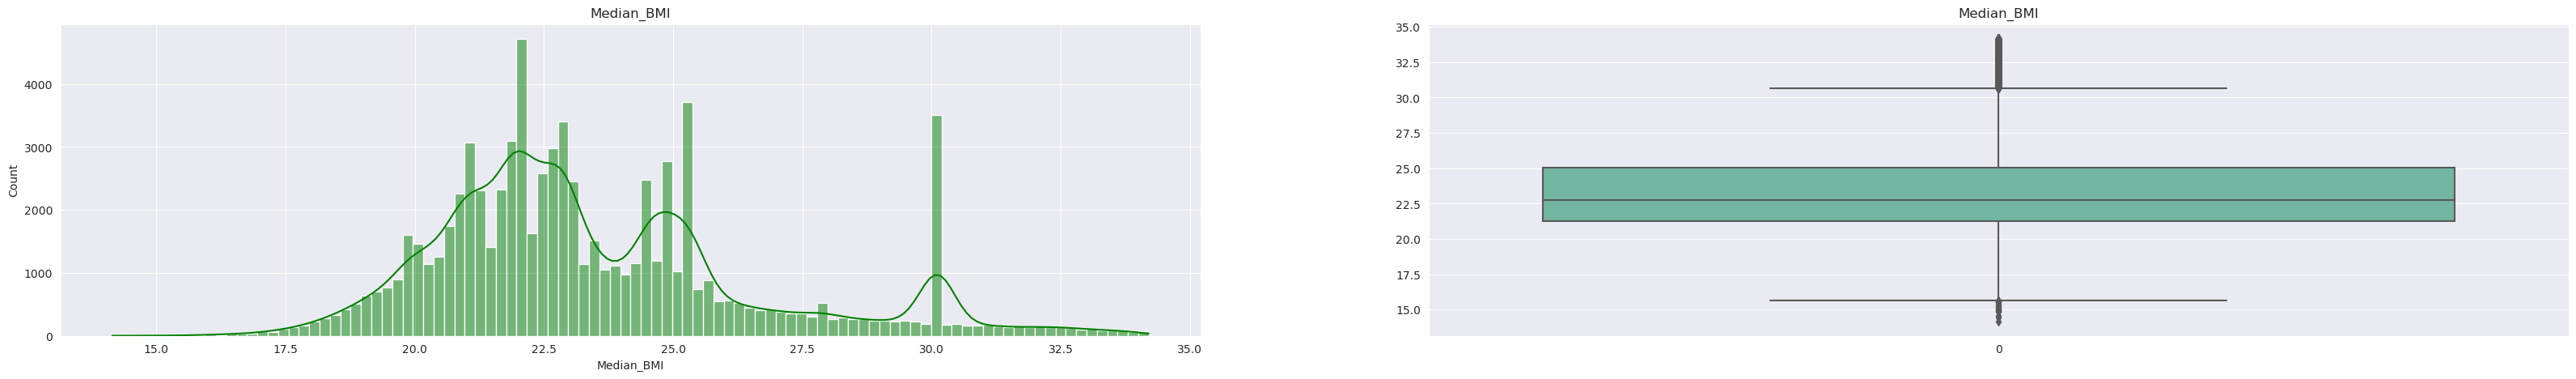

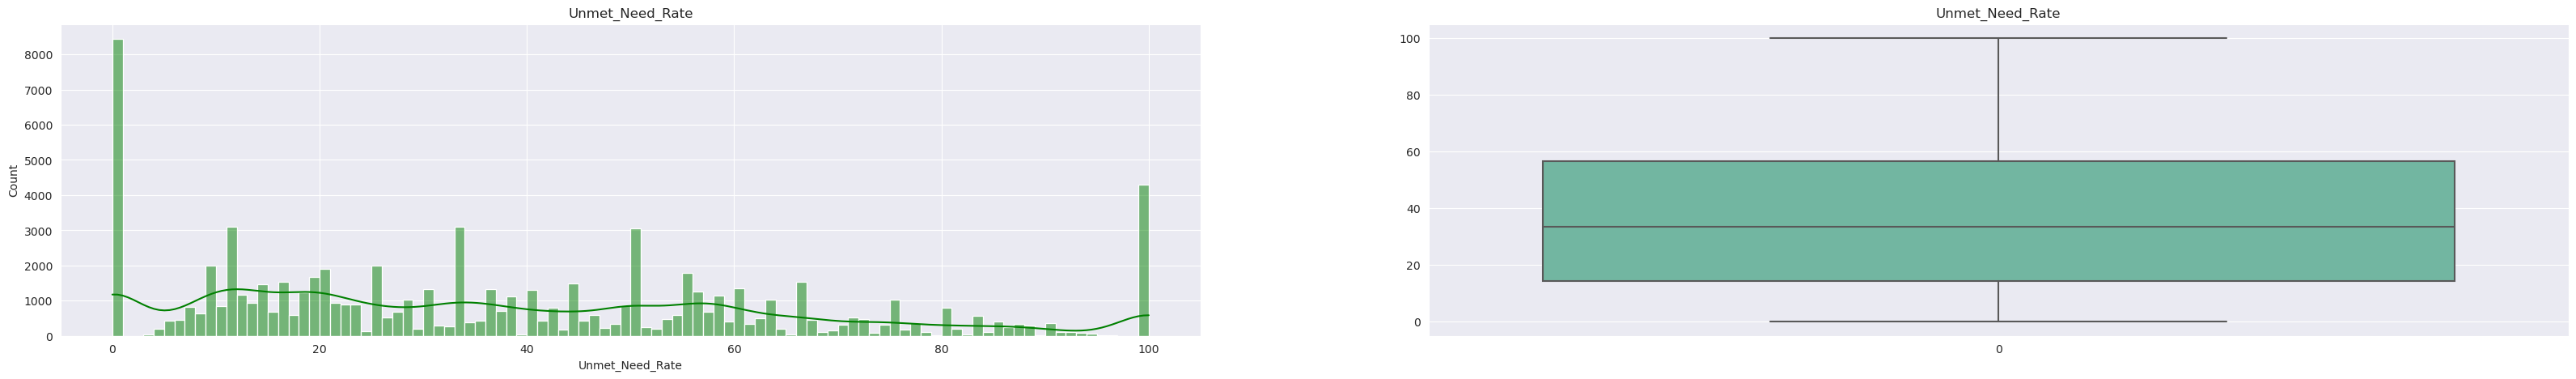

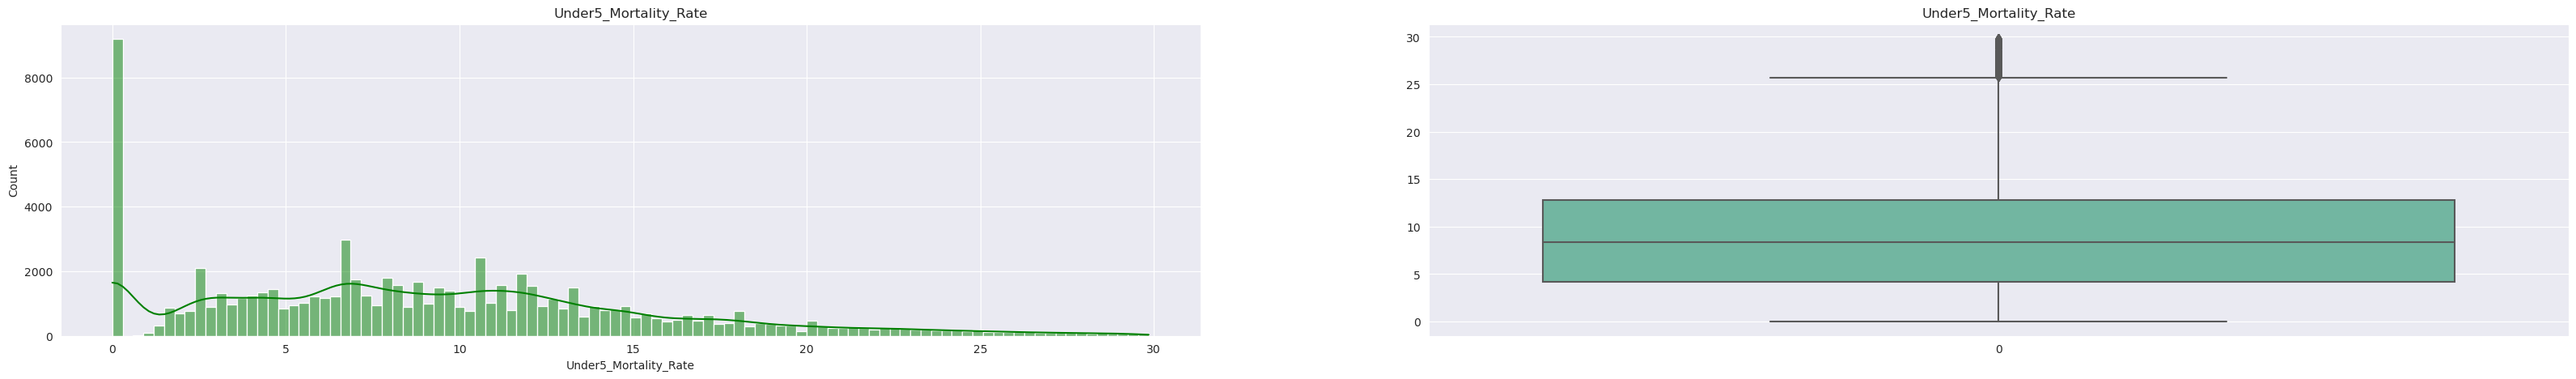

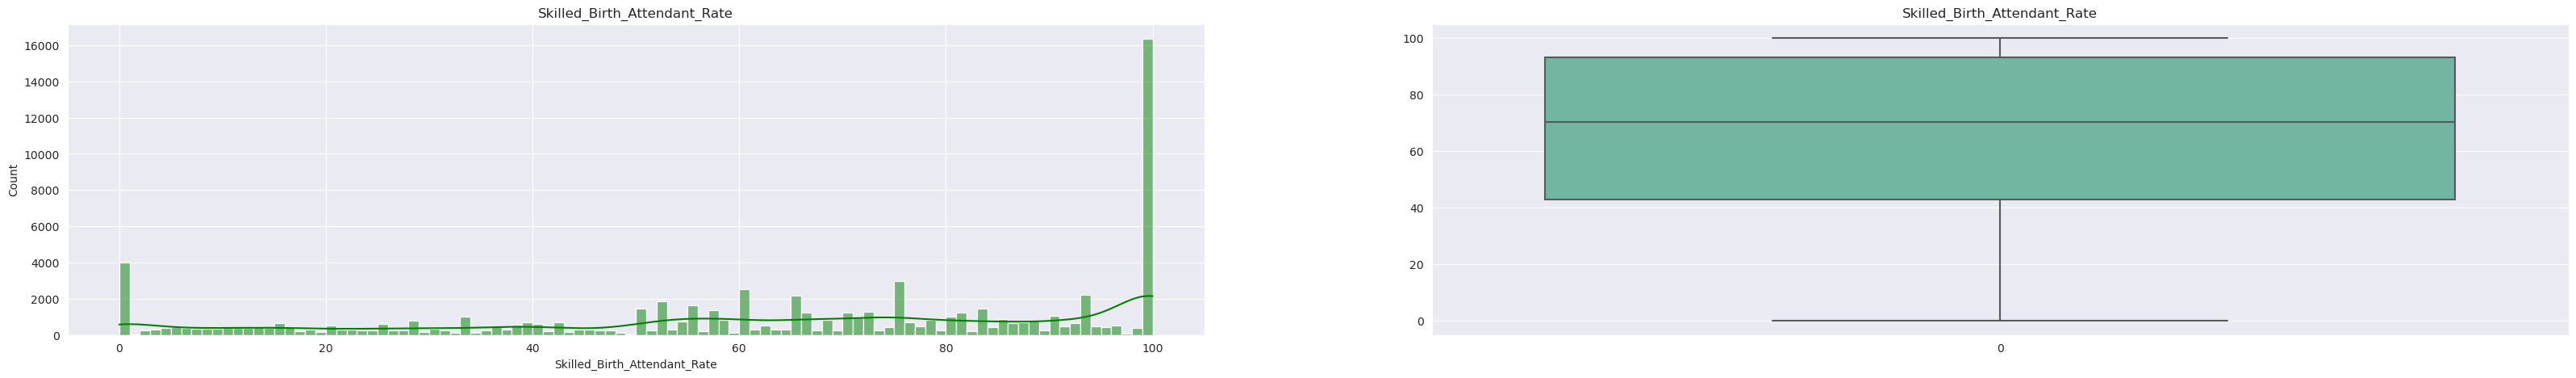

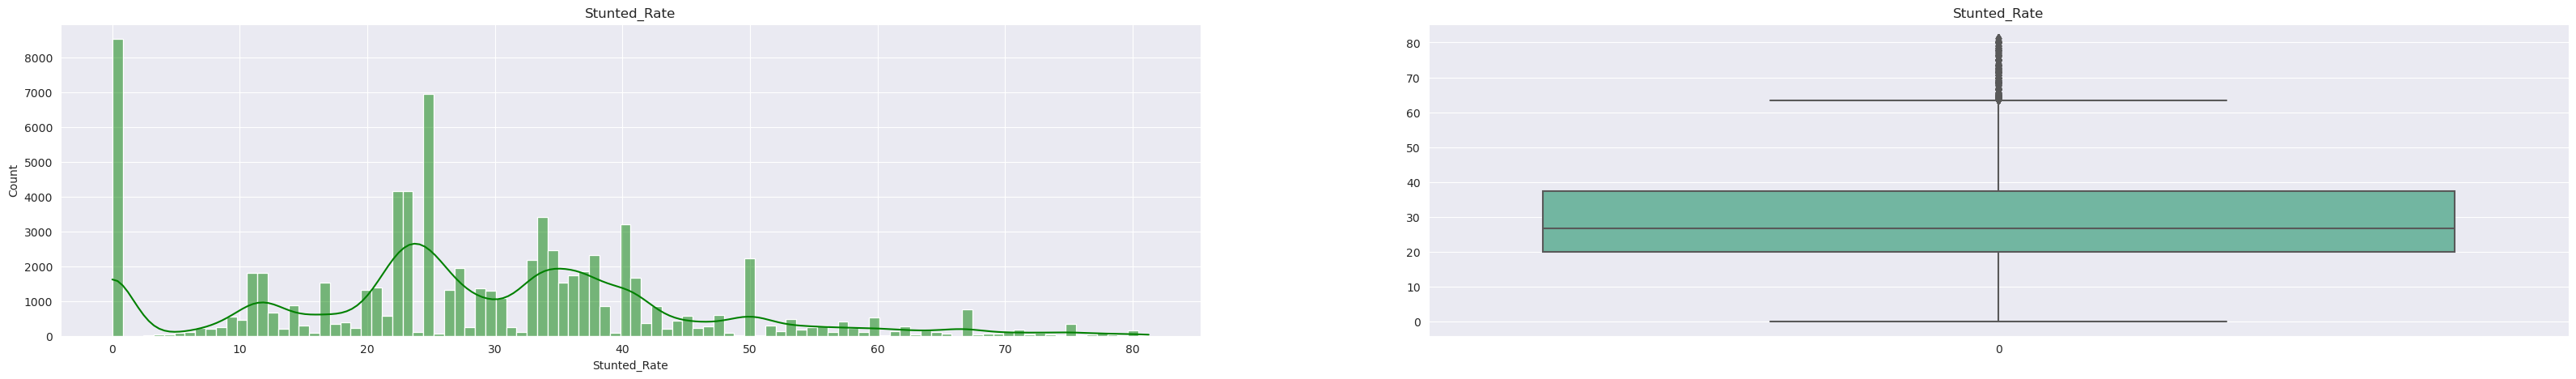

In [75]:
for column in column_names:
    comparison_plots(df_5,column)

In [76]:
df_5

,DHSID,Mean_BMI,Median_BMI,Unmet_Need_Rate,Under5_Mortality_Rate,Skilled_Birth_Attendant_Rate,Stunted_Rate
0,AL200800000001,24.120000,25.280000,50.000000,9.680000,100.000000,20.000000
1,AL200800000002,23.040000,21.980000,7.690000,8.330000,66.670000,0.000000
2,AL200800000003,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095
3,AL200800000004,26.740000,26.570000,7.690000,2.860000,100.000000,0.000000
4,AL200800000005,25.059406,24.434744,30.633723,1.753384,71.819921,16.425095
...,...,...,...,...,...,...,...
77943,ZW201500000396,23.160000,22.140000,33.330000,2.040000,78.950000,25.000000
77944,ZW201500000397,24.330000,22.610000,11.110000,1.750000,76.190000,22.220000
77945,ZW201500000398,23.700000,21.440000,10.530000,4.880000,68.000000,17.650000
77946,ZW201500000399,23.719336,22.992242,17.691171,6.484954,75.459806,30.248275


In [77]:
# Save the DataFrame as a CSV file
df_5.to_csv('training_label_preprocessed.csv', index=False)